In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [3]:
print(torch.__version__)

1.6.0+cu101


In [4]:
path = "/content/"

cifar10 = datasets.CIFAR10(path, train=True, download=True)
cifar10_val = datasets.CIFAR10(path, train=False, download=True)


Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


In [5]:
# Appending it to transform.Compose
transformed_cifar10 = datasets.CIFAR10(path, train=True, download=False,
                                  transform=transforms.Compose([
                                            transforms.ToTensor(),
                                             transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                                  (0.2470, 0.2435, 0.2616))]))

transformed_cifar10_val = datasets.CIFAR10(path, train=False, download=False,
                                  transform=transforms.Compose([
                                            transforms.ToTensor(),
                                             transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                                  (0.2470, 0.2435, 0.2616))]))


In [6]:
label_map = {0:0, 2:1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]

cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]


In [6]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

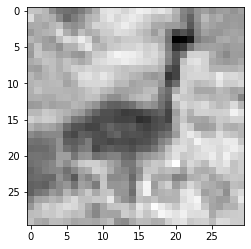

In [8]:
plt.imshow(output[0,0].detach(), cmap="gray")
plt.show()


### PADDING


In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [10]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [11]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv


Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [12]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [13]:
pool = nn.MaxPool2d(2)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape


(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [14]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2))



 ### MODEL PARAMETERS

In [16]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list


(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [17]:
model(img.unsqueeze(0))


RuntimeError: ignored

In [11]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    # import pdb; pdb.set_trace()
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8 * 8 * 8) # This is the reshaping that lead to error earlier
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out


In [19]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list


(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [20]:
model = Net()


In [21]:
model(img.unsqueeze(0))


tensor([[-0.0839, -0.0145]], grad_fn=<AddmmBackward>)

In [22]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs+1):
    loss_train = 0.0
    
    for imgs, labels in train_loader:

      output = model(imgs)
      loss = loss_fn(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()
    
    if epoch == 1 or epoch % 10 == 0:
      print("Epoch {}, Training Loss {}".format(epoch, loss_train/len(train_loader)))


In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)


Epoch 1, Training Loss 0.5515962161455944
Epoch 10, Training Loss 0.3280561551166947
Epoch 20, Training Loss 0.3045639114300157
Epoch 30, Training Loss 0.28168152206262964
Epoch 40, Training Loss 0.25628449260049563
Epoch 50, Training Loss 0.23607337299236067
Epoch 60, Training Loss 0.21763825791466768
Epoch 70, Training Loss 0.20263591484659038
Epoch 80, Training Loss 0.18797679795960712
Epoch 90, Training Loss 0.17245738825220971
Epoch 100, Training Loss 0.1613710879045687


### MEASURING ACCURACY

In [30]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):

  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        output = model(imgs)
        _, predicted = torch.max(output, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
      
      print("Acccuracy {}: {:.2f}".format(name, correct/total))
      


In [27]:
validate(model, train_loader, val_loader)


Acccuracy train: 0.93
Acccuracy val: 0.90


### LOADING AND SAVING MODEL

In [30]:
## SAVING
path = "/content/"
torch.save(model.state_dict(), path + "birds_vs_airplane.pt")


In [33]:
## LOADING
loaded_model = Net()
loaded_model.load_state_dict(torch.load(path + "birds_vs_airplane.pt"))
### OR 
# loaded_model_1 = torch.load(path + "birds_vs_airplane.pt")


<All keys matched successfully>

### TRAINING ON GPU

In [6]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device {device}")


Training on device cuda


In [35]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      output = model(imgs)
      loss = loss_fn(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print("Epoch {}, Training Loss {}".format(epoch, loss_train/len(train_loader)))


In [36]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [30]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)



Epoch 1, Training Loss 0.5939102051364389
Epoch 10, Training Loss 0.33127656075984807
Epoch 20, Training Loss 0.2942545288687299
Epoch 30, Training Loss 0.27302297418284566
Epoch 40, Training Loss 0.2543806623975942
Epoch 50, Training Loss 0.23674017523124719
Epoch 60, Training Loss 0.22037435484350107
Epoch 70, Training Loss 0.20441513081454926
Epoch 80, Training Loss 0.18837230310888048
Epoch 90, Training Loss 0.17447330703021616
Epoch 100, Training Loss 0.1636549219204362


PYTORCH ALWAYS LOAD THE MODEL ON THE SAME DEVICE IT WAS SAVED ON.



In [31]:
## SAVING
path = "/content/"
torch.save(model.state_dict(), path + "birds_vs_airplane.pt")


In [32]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(path + "birds_vs_airplane.pt", map_location=device))


<All keys matched successfully>

## REDUCING OVERFITTING

### REGULARIZATION

In [12]:
def training_loop_l2(n_epochs, optimizer, model, loss_fn, train_loader):

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      output = model(imgs)
      loss = loss_fn(output, labels)

      l2_lambda = 0.001
      ## For L2
      l2_norm = sum(p.pow(2).sum() for p in model.parameters())

      ## FOR L1
      # l1_norm = sum(p.abs().sum() for p in model.parameters())

      loss += l2_lambda * l2_norm

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print("Epoch {}, Training Loss {}".format(epoch, loss_train/len(train_loader)))


In [17]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)

print("\nVALIDATION")
validate(model, train_loader, val_loader)


Epoch 1, Training Loss 0.5974473778609257
Epoch 10, Training Loss 0.36210501393315137
Epoch 20, Training Loss 0.32437379079259887
Epoch 30, Training Loss 0.30244490115126227
Epoch 40, Training Loss 0.2810675973535343
Epoch 50, Training Loss 0.2663441857524738
Epoch 60, Training Loss 0.2544705247992923
Epoch 70, Training Loss 0.23951430466904003
Epoch 80, Training Loss 0.23005347765365225
Epoch 90, Training Loss 0.21909236561530715
Epoch 100, Training Loss 0.20819884704746258

VALIDATION
Accuracy train: 0.91
Accuracy val: 0.86


### DROPOUT

Dropout is normally active during training, while during the evaluation of the trainined model, dropout is bypassed. 

In [24]:
class NetDroupout(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv1_dropout = nn.Dropout2d(p=0.4)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.conv2_dropout = nn.Dropout2d(p=0.4)
    self.fc1 = nn.Linear(8 * 8 * 16, 32)
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = self.conv1_dropout(out)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = self.conv2_dropout(out)
    out = out.view(-1, 8 * 8 * 16)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out


In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = NetDroupout().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)

print("\nVALIDATION")
validate(model, train_loader, val_loader)


Epoch 1, Training Loss 0.5862620474806257
Epoch 10, Training Loss 0.3829476401494567
Epoch 20, Training Loss 0.34312245439571937
Epoch 30, Training Loss 0.3282558438694401
Epoch 40, Training Loss 0.3080754356019816
Epoch 50, Training Loss 0.2980665618636806
Epoch 60, Training Loss 0.2820053290409647
Epoch 70, Training Loss 0.26867131784463383
Epoch 80, Training Loss 0.2581149933824114
Epoch 90, Training Loss 0.24881312198889483
Epoch 100, Training Loss 0.2383650402734234

VALIDATION
Accuracy train: 0.90
Accuracy val: 0.88


### BATCH NORMALIZATION

In [26]:
class NetBatchNorm(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=32)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=16)
    self.fc1 = nn.Linear(8 * 8 * 16, 32)
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = self.conv1_batchnorm(self.conv1(x))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = self.conv2_batchnorm(self.conv2(out))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = out.view(-1, 8 * 8 * 16)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out


In [27]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = NetBatchNorm().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)

print("\nVALIDATION")
validate(model, train_loader, val_loader)


Epoch 1, Training Loss 0.4368841837925516
Epoch 10, Training Loss 0.26768919626239
Epoch 20, Training Loss 0.21919365730255272
Epoch 30, Training Loss 0.1746390621136328
Epoch 40, Training Loss 0.1332811345435252
Epoch 50, Training Loss 0.10376007716129919
Epoch 60, Training Loss 0.07638439326102187
Epoch 70, Training Loss 0.059155750521429025
Epoch 80, Training Loss 0.04539630045983822
Epoch 90, Training Loss 0.025603928303666364
Epoch 100, Training Loss 0.01972709780938591

VALIDATION
Accuracy train: 0.99
Accuracy val: 0.88


### SKIP CONNECTIONS

In [6]:
class NetRes(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * 16, 32)
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv(out)), 2)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
    out = torch.view(-1, 4 * 4 * 16)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out


In [38]:
class ResBlock(nn.Module):
  def __init__(self):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=32)

    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)
  
  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x
  
class NetResDeep(nn.Module):
  def __init__(self, n_blocks=10):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(
        *(n_blocks * [ResBlock()]))
    
    self.fc1 = nn.Linear(8 * 8 * 32, 32)
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8 * 8 * 32)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out



In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = NetResDeep().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)

print("\nVALIDATION")
validate(model, train_loader, val_loader)


Epoch 1, Training Loss 0.518364815575302
Epoch 10, Training Loss 0.2585148478674281
Epoch 20, Training Loss 0.17056205223320395
Epoch 30, Training Loss 0.11244980458193904
Epoch 40, Training Loss 0.07557323608238986
Epoch 50, Training Loss 0.02605741253941302
Epoch 60, Training Loss 0.01449058174487844
Epoch 70, Training Loss 0.00928121611214937
Epoch 80, Training Loss 0.04721920794338747
Epoch 90, Training Loss 0.06225931847906986
Epoch 100, Training Loss 0.008448980192529263

VALIDATION
Accuracy train: 1.00
Accuracy val: 0.90


## EXERCISE

### Q-1
1. The number parameters in the model decreases. Look at the following example for explanation


In [11]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

for img, label in train_loader:
  break


In [23]:
print("INPUT DIMENSION", img.shape)

conv_3 = nn.Conv2d(3,3, kernel_size=3)
print("CONV 3 DIMENSION", conv_3(img).shape)

conv_5 = nn.Conv2d(3,3, kernel_size=5)
print("CONV 5 DIMENSION", conv_5(img).shape)

### TO MAINTAIN THE SAME DIMENSION
print("\nWITH PADDING")
conv_3 = nn.Conv2d(3,3, kernel_size=3, padding=1)
print("CONV 3 DIMENSION", conv_3(img).shape)

conv_5 = nn.Conv2d(3,3, kernel_size=5, padding=2)
print("CONV 5 DIMENSION", conv_5(img).shape)


INPUT DIMENSION torch.Size([64, 3, 32, 32])
CONV 3 DIMENSION torch.Size([64, 3, 30, 30])
CONV 5 DIMENSION torch.Size([64, 3, 28, 28])

WITH PADDING
CONV 3 DIMENSION torch.Size([64, 3, 32, 32])
CONV 5 DIMENSION torch.Size([64, 3, 32, 32])


2. The model performance is more or less the same

In [31]:
class Net_5(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    # import pdb; pdb.set_trace()
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8 * 8 * 8) # This is the reshaping that lead to error earlier
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out


In [32]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):

  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      output = model(imgs)
      loss = loss_fn(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print("Epoch {}, Training Loss {}".format(epoch, loss_train/len(train_loader)))


In [33]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [35]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device {device}")

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net_5().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)

print("\nVALIDATION")
validate(model, train_loader, val_loader)


Training on device cuda
Epoch 1, Training Loss 0.6573301428442548
Epoch 10, Training Loss 0.4606309656504613
Epoch 20, Training Loss 0.36832212414711146
Epoch 30, Training Loss 0.3215897778037247
Epoch 40, Training Loss 0.30339763811819115
Epoch 50, Training Loss 0.287833470827455
Epoch 60, Training Loss 0.2744786577999212
Epoch 70, Training Loss 0.26255293432504506
Epoch 80, Training Loss 0.25339635883926587
Epoch 90, Training Loss 0.24319961828411005
Epoch 100, Training Loss 0.23388650069001374

VALIDATION
Accuracy train: 0.90
Accuracy val: 0.88


4. With __**kernel_size=(1,3)**__ the output shape will be **(3,32,30)** assuming no padding is used.

In [46]:
print("INPUT DIMENSION", img.shape)

conv_3 = nn.Conv2d(3,3, kernel_size=(1,3))
print("CONV 3 DIMENSION", conv_3(img).shape)

### TO MAINTAIN THE SAME DIMENSION
print("\nWITH PADDING")
conv_3 = nn.Conv2d(3,3, kernel_size=(1,3), padding=(0,1))
print("CONV 3 DIMENSION", conv_3(img).shape)


INPUT DIMENSION torch.Size([64, 3, 32, 32])
CONV 3 DIMENSION torch.Size([64, 3, 32, 30])

WITH PADDING
CONV 3 DIMENSION torch.Size([64, 3, 32, 32])


In [48]:
class Net_kernel(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=(1,3), padding=(0,1))
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=(1,3), padding=(0,1))
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)
  
  def forward(self, x):
    # import pdb; pdb.set_trace()
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8 * 8 * 8) # This is the reshaping that lead to error earlier
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out


5. Model performance with **kernel_size=(1,3)**

In [49]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device {device}")

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net_kernel().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn,
              train_loader=train_loader)

print("\nVALIDATION")
validate(model, train_loader, val_loader)


Training on device cuda
Epoch 1, Training Loss 0.6794808495576214
Epoch 10, Training Loss 0.48046871905873534
Epoch 20, Training Loss 0.42760546875607436
Epoch 30, Training Loss 0.36894168083075507
Epoch 40, Training Loss 0.34429767082451257
Epoch 50, Training Loss 0.3304859274511884
Epoch 60, Training Loss 0.31996135337717213
Epoch 70, Training Loss 0.3094087079831749
Epoch 80, Training Loss 0.3004894435500643
Epoch 90, Training Loss 0.2918827050620583
Epoch 100, Training Loss 0.28374449453156464

VALIDATION
Accuracy train: 0.88
Accuracy val: 0.87
